### Import libraries

In [1]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.video import VideoStream
import imutils
import time
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

### Preparing our dataset

In [2]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training config:
epochs = 20
batch_size = 15

#define paths
Mask_path = 'C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\with_mask'
NoMask_path = 'C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\without_mask'


# Use glob to grab images from path .jpg or jpeg
Mask_files = glob(Mask_path + '/*')
NoMask_files = glob(NoMask_path + '/*')
# Visualize file variable contents
print("First 5 Mask Files: ",Mask_files[0:5])
print("Total Count: ",len(Mask_files))
print("First 5 No Mask Files: ",NoMask_files[0:5])
print("Total Count: ",len(NoMask_files))

First 5 Mask Files:  ['C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\with_mask\\0-with-mask.jpg', 'C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\with_mask\\1-with-mask.jpg', 'C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\with_mask\\10-with-mask.jpg', 'C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\with_mask\\100-with-mask.jpg', 'C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\with_mask\\101-with-mask.jpg']
Total Count:  690
First 5 No Mask Files:  ['C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\without_mask\\0.jpg', 'C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\without_mask\\1.jpg', 'C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\without_mask\\10.jpg', 'C:\\Users\\ASUS\\Desktop\\TFS Foundation Tasks\\Computer vision\\dataset\\without_mask\\100.jpg', 'C:\\Users\\ASUS\\D

In [3]:
# Merge sets for both types of images
Mask_NoMask_images=[]
labels=[]
images = np.concatenate((Mask_files, NoMask_files), axis=0)
for path in images:
    label=path.split(os.path.sep)[-2]
    image = cv2.imread(path) # read file 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
    image = cv2.resize(image,(224,224)) # resize as per model
    Mask_NoMask_images.append(image)
    labels.append(label)

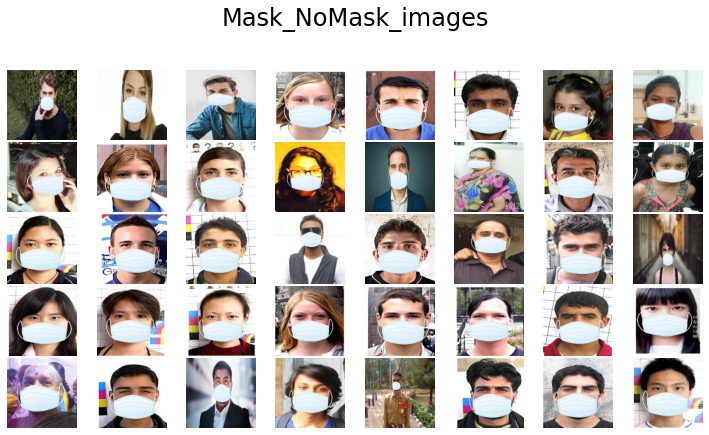

In [4]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(Mask_NoMask_images, 'Mask_NoMask_images')

In [5]:
# Convert to array and Normalize to interval of [0,1]
Mask_NoMask_images = np.array(Mask_NoMask_images) / 255

# Make labels into categories - either 0 ,1, for our model
labels = preprocessing.LabelEncoder().fit_transform(labels)
labels = to_categorical(labels)
print('labels',labels)

labels [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


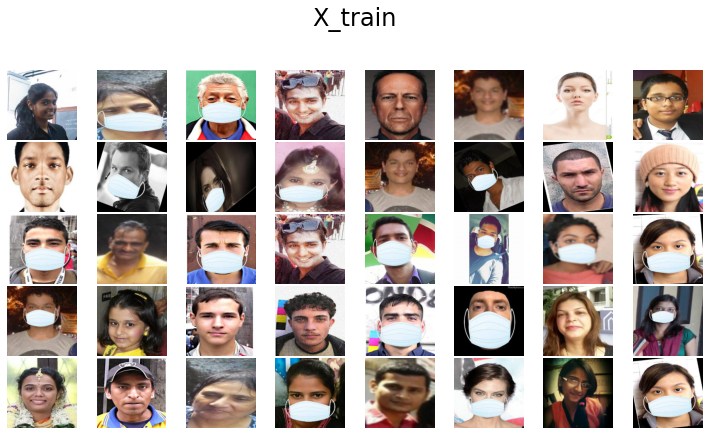

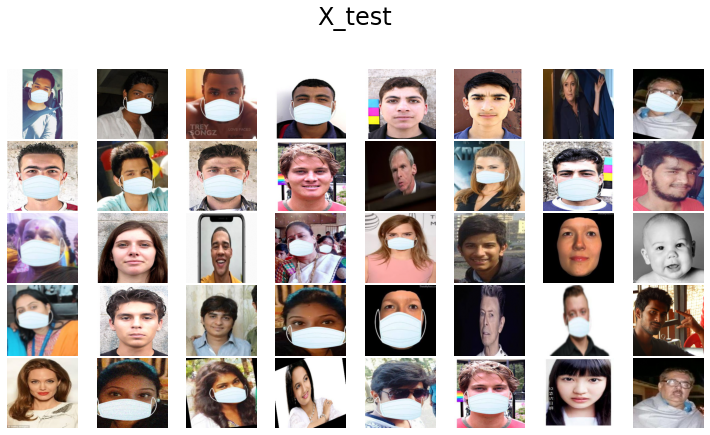

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    Mask_NoMask_images, labels, test_size=0.2)

plot_images(x_train, 'X_train')
plot_images(x_test, 'X_test')

### Building Model

In [7]:
# Building Model

VModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = VModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="sigmoid")(outputs)

model = Model(inputs=VModel.input, outputs=outputs)

for layer in VModel.layers:
    layer.trainable = False

model.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    horizontal_flip=True
)

In [8]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [9]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [10]:
history = model.fit(train_aug.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    validation_steps=len(x_test) / batch_size,
                    steps_per_epoch=len(x_train) / batch_size,
                     epochs=epochs)

Epoch 1/20
73/73 [==============================] - 77s 952ms/step - loss: 0.1006 - accuracy: 0.9800 - val_loss: 0.0333 - val_accuracy: 0.9964
Epoch 2/20
73/73 [==============================] - 52s 698ms/step - loss: 0.0784 - accuracy: 0.9900
Epoch 3/20
73/73 [==============================] - 54s 736ms/step - loss: 0.0550 - accuracy: 0.9964
Epoch 4/20
73/73 [==============================] - 54s 729ms/step - loss: 0.0209 - accuracy: 1.0000
Epoch 5/20
73/73 [==============================] - 54s 730ms/step - loss: 0.0500 - accuracy: 0.9982
Epoch 6/20
73/73 [==============================] - 53s 722ms/step - loss: 0.0326 - accuracy: 0.9973
Epoch 7/20
73/73 [==============================] - 52s 709ms/step - loss: 0.0253 - accuracy: 0.9982
Epoch 8/20
73/73 [==============================] - 53s 715ms/step - loss: 0.0500 - accuracy: 0.9955
Epoch 9/20
73/73 [==============================] - 53s 719ms/step - loss: 0.0354 - accuracy: 0.9991
Epoch 10/20
73/73 [==============================

### Prediction

In [11]:
y_pred = model.predict(x_test, batch_size=batch_size)
predIdxs = np.argmax(y_pred, axis=1)
# show a nicely formatted classification report
#print(classification_report(y_test.argmax(axis=1), predIdxs))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model", save_format="h5")

19/19 [==============================] - 13s 582ms/step
[INFO] saving mask detector model...


### plots

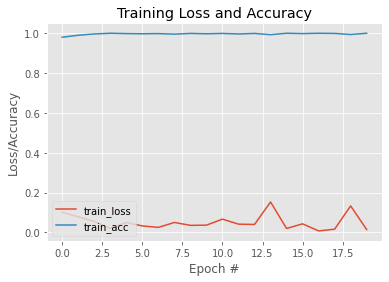

In [12]:
# plot the training loss and accuracy
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plotT4")

### Implementing our COVID-19 face mask detector for images with OpenCV

In [13]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
# extract the confidence (i.e., probability) associated with
# the detection
        confidence = detections[0, 0, i, 2]

# filter out weak detections by ensuring the confidence is
# greater than the minimum confidence
        if confidence > 0.5:
# compute the (x, y)-coordinates of the bounding box for
# the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

# ensure the bounding boxes fall within the dimensions of
# the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

# extract the face ROI, convert it from BGR to RGB channel
# ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

# add the face and bounding boxes to their respective
# lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

# only make a predictions if at least one face was detected
    if len(faces) > 0:
# for faster inference we'll make batch predictions on *all*
# faces at the same time rather than one-by-one predictions
# in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

# return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

In [21]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(['C:/Users/ASUS/Desktop/TFS Foundation Tasks/Computer vision/face_detector', "deploy.prototxt"])
weightsPath = os.path.sep.join(['C:/Users/ASUS/Desktop/TFS Foundation Tasks/Computer vision/face_detector',"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
# grab the frame from the threaded video stream and resize it
# to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

# detect faces in the frame and determine if they are wearing a
# face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)

# loop over the detected face locations and their corresponding
# locations
    for (box, pred) in zip(locs, preds):
# unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

# show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] loading face detector model...
[INFO] starting video stream...
